# **IMPORTADO DE MÓDULOS**

In [ ]:
import numpy as np

import os
import time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras import initializers
from keras.regularizers import l2
import keras.backend as K

In [ ]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [ ]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **PREPROCESSING AND FUNCTIONS**

In [ ]:
start = 50
stop = 80
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start:stop,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start:stop,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start:stop,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


Text(0.5, 1.0, 'Real pulses')

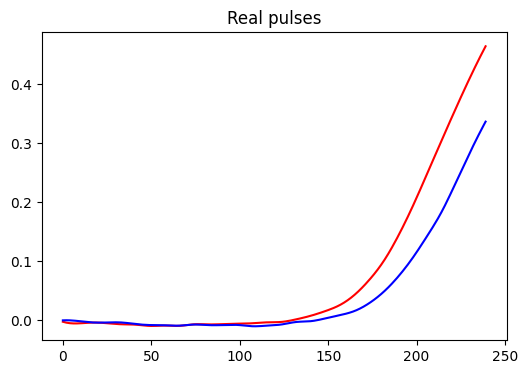

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(new_V28[0,:,0],'r-')
plt.plot(new_V28[0,:,1],'b-')
plt.title('Real pulses')

In [ ]:
def momentos(vector):
  Nev,Nt,Nc = np.shape(vector)    #Nev: Núm eventos, Nt: Núm puntos temporales, Nc: Número canales
  t = np.reshape(np.linspace(0,Nt, Nt)/float(Nt),(1,-1,1))#Normalized array of time
  MOMENT = np.zeros((Nev,0,Nc))

  for i in range(4): #Number of moments used
    W = t**(i+1)
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

    W = np.exp(-(i)*t)
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

    W = np.exp(-t**(i))   #Salia bien sin esto vamos aprobar
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

  return MOMENT

In [ ]:
Num_casos = 10000
Nc = 2
t_shift = 8 #In time steps #12
t0 = 65 + np.random.randint(5, size=Num_casos) #65

# **DETECTOR 0**

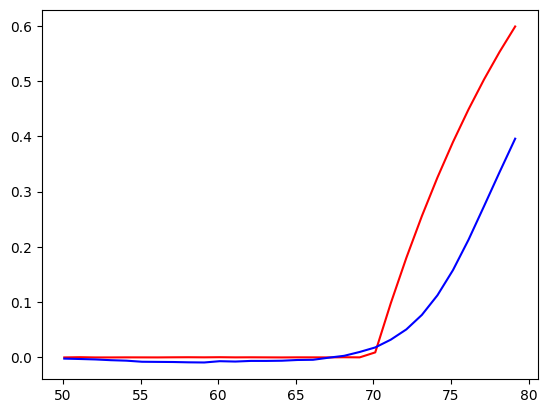

In [ ]:
def pulso(t,t0):
  noise = np.random.normal(scale=0.01, size=len(t)-t0)
  noise2 = np.random.normal(scale=1e-4, size=t0)
  smoothed_noise = gaussian_filter1d(noise, sigma=30)
  y=(1-np.exp(-(t-t0)/15))*np.exp(-(t-t0)/150) #15
  y[y<0.] = 0
  y[t0:] = y[t0:] + smoothed_noise
  y[:t0] = y[:t0] + noise2
  y = y / np.max(y)
  return y

tt=np.linspace(0,600,600)   #time step of 0.2ns
pulso_original = pulso(tt,70)


plt.plot(tt[start:stop],pulso_original[start:stop],'r-')
plt.plot(tt[start:stop],V55[0,start:stop,0],'b-')

In [ ]:
INPUT_dec0 = np.zeros((Num_casos,Nt_new,Nc))

for i in range(Num_casos):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size=t_shift)
  PULSO = pulso(tt,centro)
  interp_func = interp1d(tiempo,PULSO[start:stop], kind='cubic')
  PULSO = interp_func(tiempo_new)
  INPUT_dec0[i,:,0] = PULSO
  INPUT_dec0[i,:,1] = np.roll(PULSO, t_shift)
  INPUT_dec0[i,0:t_shift,1] = noise

In [ ]:
Ncasos=INPUT_dec0.shape[0]
REF_dec0 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(32, size=Ncasos) #100
NRD1 = np.random.randint(32, size=Ncasos) #100

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-4, size=N0)
  INPUT_dec0[i,:,0]=np.roll(INPUT_dec0[i,:,0],N0)
  INPUT_dec0[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-4, size=N1)
  INPUT_dec0[i,:,1]=np.roll(INPUT_dec0[i,:,1],N1)
  INPUT_dec0[i,0:N1,1] = noise1
  REF_dec0[i]=new_time_step*(N0-N1-t_shift)  #in ns (t_shift is defined above) LE CAMBIE EL SIGNO A T_SHIFT PARA VER SI AYUDA A V28

Ntrain = np.floor(0.8*Ncasos).astype(int)

trainX_dec0 = INPUT_dec0[0:Ntrain,:,:]
valX_dec0 = INPUT_dec0[Ntrain:,:,:]

REF_train_dec0 = REF_dec0[0:Ntrain]
REF_val_dec0 = REF_dec0[Ntrain:]

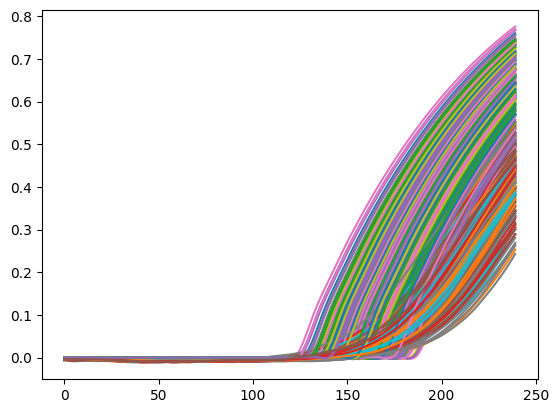

In [ ]:
for i in range(new_V55.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
  plt.plot(new_V55[i,:,0])

In [ ]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Val_dec0 = momentos(valX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)
M_Val_dec0 = (M_Val_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)

(8000, 12, 2) NM = 12


# **DETECTOR 1**

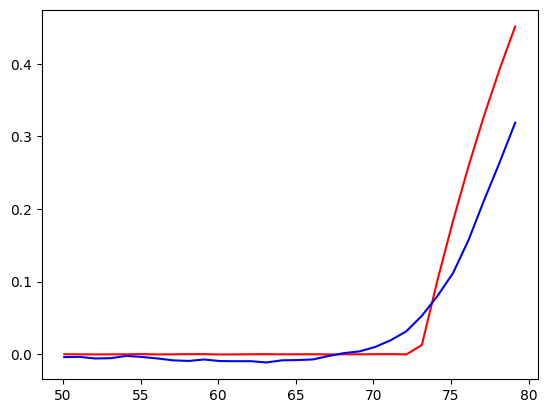

In [ ]:
def pulso_dec1(t,t0):
  noise = np.random.normal(scale=0.01, size=len(t)-t0)
  noise2 = np.random.normal(scale=1e-4, size=t0)
  smoothed_noise = gaussian_filter1d(noise, sigma=10)
  y=(1-np.exp(-(t-t0)/15))*np.exp(-(t-t0)/150) #15
  y[y<0.] = 0
  y[t0:] = y[t0:] + smoothed_noise
  y[:t0] = y[:t0] + noise2
  y = y / np.max(y)
  return y

tt=np.linspace(0,600,600)   #time step of 0.2ns
pulso_original = pulso_dec1(tt,73)

plt.plot(tt[start:stop],pulso_original[start:stop],'r-')
plt.plot(tt[start:stop],V55[0,start:stop,1],'b-')

In [ ]:
INPUT_dec1 = np.zeros((Num_casos,Nt_new,Nc))

for i in range(Num_casos):
  centro = t0[i]
  noise = np.random.normal(scale=1e-4, size=t_shift)
  PULSO = pulso_dec1(tt,centro)
  interp_func = interp1d(tiempo,PULSO[start:stop], kind='cubic')
  PULSO = interp_func(tiempo_new)
  INPUT_dec1[i,:,0] = PULSO
  INPUT_dec1[i,:,1] = np.roll(PULSO, t_shift)
  INPUT_dec1[i,0:t_shift,1] = noise

In [ ]:
Ncasos=INPUT_dec1.shape[0]
REF_dec1 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(32, size=Ncasos) #100
NRD1 = np.random.randint(32, size=Ncasos) #100

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-4, size=N0)
  INPUT_dec1[i,:,0]=np.roll(INPUT_dec1[i,:,0],N0)
  INPUT_dec1[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-4, size=N1)
  INPUT_dec1[i,:,1]=np.roll(INPUT_dec1[i,:,1],N1)
  INPUT_dec1[i,0:N1,1] = noise1
  REF_dec1[i]=new_time_step*(N0-N1-t_shift)  #in ns (t_shift is defined above)

Ntrain = np.floor(0.8*Ncasos).astype(int)

trainX_dec1 = INPUT_dec1[0:Ntrain,:,:]
valX_dec1 = INPUT_dec1[Ntrain:,:,:]

REF_train_dec1 = REF_dec1[0:Ntrain]
REF_val_dec1 = REF_dec1[Ntrain:]

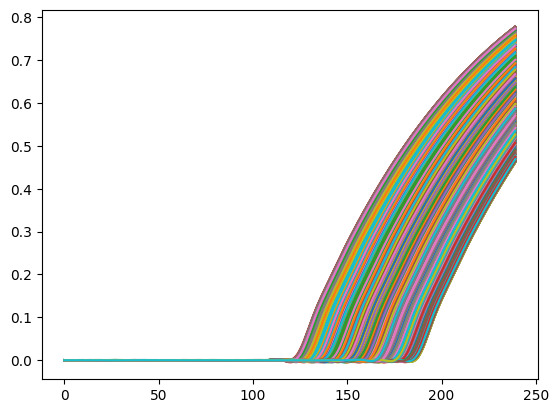

In [ ]:
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])

In [ ]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)
M_Val_dec1 = momentos(valX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)
M_Val_dec1 = (M_Val_dec1-min_dec1)/(max_dec1 - min_dec1)


NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)

(8000, 12, 2) NM = 12


# **FULL TOF**

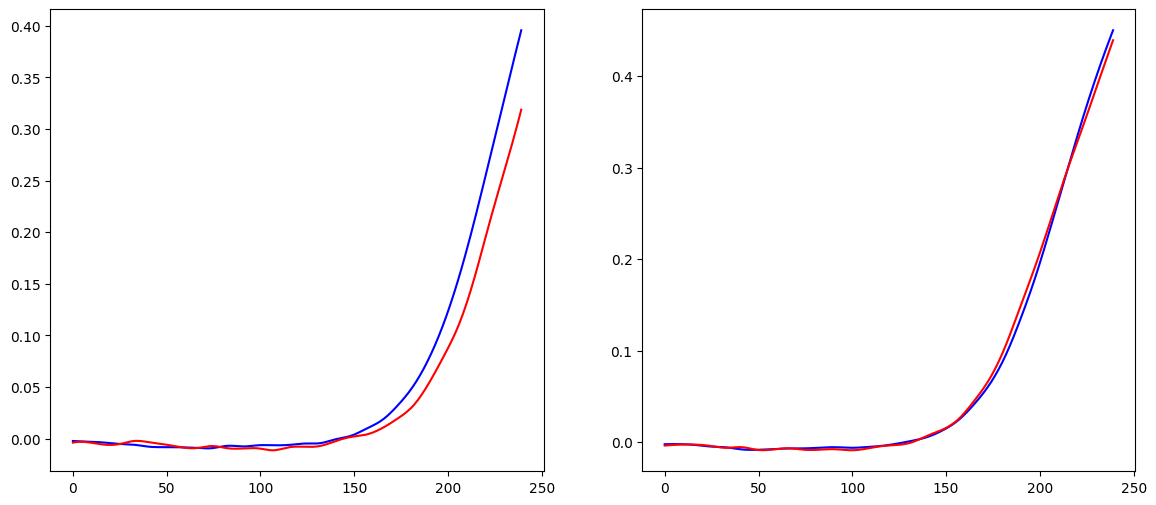

In [ ]:
plt.figure(figsize = (14,6))
plt.subplot(121)
plt.plot(new_V55[0,:,0],'b')
plt.plot(new_V55[0,:,1],'r')

plt.subplot(122)
plt.plot(new_V82[10,:,0],'b')
plt.plot(new_V82[10,:,1],'r')


#ENTRE EVENTO Y EVENTE PARECE QUE HAY DIFERENCIA EN COMO SE DESPLAZA LA SEÑAL EN UN DETECT Y EL OTRO

In [ ]:
REFERENCE_PULSE_dec0 = np.tile(new_V82[0,:,0], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V82[0,:,1], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)


M_V28 = momentos(new_V28)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(new_V55)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(new_V82)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)


(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [ ]:
def weights_definition(NM, Npoints):
  t = np.linspace(0,Npoints, Npoints)/float(Npoints) #Normalized array of time
  Weights = np.zeros((Npoints,NM))
  NMW = int(NM/3) #Number of Moments per weight

  for i in range(NMW):
    Weights[:,i] = t**(i+1)

  for i in range(NMW):
    Weights[:,i + NMW] = np.exp(-t**(i))

  for i in range(NMW):
    Weights[:,i + 2*(NMW)] = np.exp(-(i)*t)

  return Weights

#------------------------------------------------------------------------------------------
NM = 12
weights = weights_definition(NM,Nt_new)

In [ ]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))

  x1 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(32, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")
  #32 neuronas con inicialización gaussiana de std 0.5/1 parece ser la más estable en cuanto a semilla


  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

#------------------------------------------------------------------------------------------------------

def model_definition_manual_weight_initialization(N_time_points):

  inputA = Input(shape=(N_time_points,))
  inputB = Input(shape=(N_time_points,))

  x1 = Dense(NM, activation="relu", weights=[weights, np.zeros(NM)])
  #x1 = Dense(NM, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x2 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x3 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x4 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x5 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  op4A = x4(op3A)
  outA = x5(op4A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  op4B = x4(op3B)
  outB = x5(op4B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model


In [ ]:
import os

# Set CUDA_VISIBLE_DEVICES to an empty string to force TensorFlow to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [ ]:
Ntries= 20

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

directory = '/home/josea/DEEP_TIMING/simulados/'


for i in range(Ntries):
  #model_dec0 = model_definition(Nt_new)
  #model_dec1 = model_definition(Nt_new)

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=7e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=7e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0,validation_data=([M_Val_dec0[:,:,0], M_Val_dec0[:,:,1]], REF_val_dec0), epochs=250, batch_size = 256, shuffle = True, verbose=0)
  history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1,validation_data=([M_Val_dec1[:,:,0], M_Val_dec1[:,:,1]], REF_val_dec1), epochs=250, batch_size = 256, shuffle = True, verbose=0)

  #history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0,validation_data=([valX_dec0[:,:,0], valX_dec0[:,:,1]], REF_val_dec0), epochs=250, batch_size = 512, shuffle = True, verbose=0)
  #history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1,validation_data=([valX_dec1[:,:,0], valX_dec1[:,:,1]], REF_val_dec1), epochs=250, batch_size = 512, shuffle = True, verbose=0)

  TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
  TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
  TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
  TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])
  TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
  TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])

  #TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V82.shape[0],:,0],new_V82[:,:,0]])
  #TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V82.shape[0],:,0],new_V82[:,:,1]])
  #TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V55.shape[0],:,0],new_V55[:,:,0]])
  #TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V55.shape[0],:,0],new_V55[:,:,1]])
  #TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:new_V28.shape[0],:,0],new_V28[:,:,0]])
  #TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:new_V28.shape[0],:,0],new_V28[:,:,1]])

  TOFN_V82 = TOFN_dec0_REF_V82-TOFN_dec1_REF_V82
  TOFN_V55 = TOFN_dec0_REF_V55-TOFN_dec1_REF_V55
  TOFN_V28 = TOFN_dec0_REF_V28-TOFN_dec1_REF_V28

  TOFN_V28_list.append(TOFN_V28)
  TOFN_V55_list.append(TOFN_V55)
  TOFN_V82_list.append(TOFN_V82)

  #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
  #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')


TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

In [ ]:
for i in range(TOFN_V28_array.shape[0]):
  centroid_V28 = -1*np.mean(TOFN_V28_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  centroid_V82 = -1*np.mean(TOFN_V82_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82-0.2)) / 2
  mean_std = (np.std(TOFN_V82_array[i,:]) + np.std(TOFN_V55_array[i,:]) + np.std(TOFN_V28_array[i,:])) / 3

  epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
  print('index: %d  %.3f %.3f %.3f' % (i, mean_std, mean_error_centroid,epsilon))


V82: CENTROID(ns) = 0.180  FWHM(ns) = 0.164  std(ns) = 0.073
V55: CENTROID(ns) = 0.006  FWHM(ns) = 0.144  std(ns) = 0.062
V28: CENTROID(ns) = -0.200  FWHM(ns) = 0.215  std(ns) = 0.086


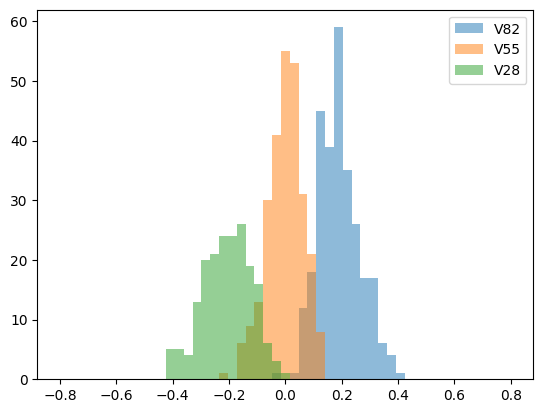

In [ ]:
index = 6
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, np.std(TOFN_V82_array[index])))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, np.std(TOFN_V55_array[index])))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, np.std(TOFN_V28_array[index])))

In [ ]:
epochs = 400
num_semillas = 10

resolution = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):
  #seed_value = i*10
  #tf.random.set_seed(seed_value)

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  #model_dec0 = model_definition_manual_weight_initialization(Nt_new)
  #model_dec1 = model_definition_manual_weight_initialization(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=5e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=5e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  epsilon = []
  loss_dec0 = []
  loss_dec1 = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0,validation_data=([M_Val_dec0[:,:,0], M_Val_dec0[:,:,1]], REF_val_dec0), epochs=1, batch_size = 256, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1,validation_data=([M_Val_dec1[:,:,0], M_Val_dec1[:,:,1]], REF_val_dec1), epochs=1, batch_size = 256, shuffle = True, verbose=1)

     #history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0,validation_data=([valX_dec0[:,:,0], valX_dec0[:,:,1]], REF_val_dec0), epochs=1, batch_size = 256, verbose=1)
     #history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1,validation_data=([valX_dec1[:,:,0], valX_dec1[:,:,1]], REF_val_dec1), epochs=1, batch_size = 256, verbose=1)

     TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])

     #TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:V82_fraction.shape[0],:,0],new_V82[:,:,0]])
     #TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:V82_fraction.shape[0],:,0],new_V82[:,:,1]])
     #TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:V55_fraction.shape[0],:,0],new_V55[:,:,0]])
     #TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:V55_fraction.shape[0],:,0],new_V55[:,:,1]])
     #TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:V28_fraction.shape[0],:,0],new_V28[:,:,0]])
     #TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:V28_fraction.shape[0],:,0],new_V28[:,:,1]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82

     centroid_V28 = -1*np.mean(TOFN_V28) + np.mean(TOFN_V55)
     centroid_V82 = -1*np.mean(TOFN_V82) + np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     epsilon.append(np.sqrt(mean_error_centroid**2 + mean_std**2))

     loss_dec0.append(history_dec0.history['loss'])
     loss_dec1.append(history_dec1.history['loss'])

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  resolution.append(epsilon)

  TOFN_V28_list.append(TOFN_V28)
  TOFN_V55_list.append(TOFN_V55)
  TOFN_V82_list.append(TOFN_V82)

resolution = np.array(resolution, dtype = 'object')
training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

In [ ]:
resolution = np.array(resolution, dtype='float64')
training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')

print(np.where(resolution == np.min(resolution)), np.min(resolution))
index = 1
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(resolution.shape[0]):
  plt.plot(np.log10(resolution[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Semilla' + ' ' + str(i)
  plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  #plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')


plt.subplot(2,2,3)
plt.plot(np.log10(resolution[index,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()

# **ENSEMBLE MODEL**

In [ ]:
#--------------------------- Get the mean results from all tries/seeds --------------------------
mean_V28 = np.squeeze(np.mean(TOFN_V28_array, axis=0))
mean_V55 = np.squeeze(np.mean(TOFN_V55_array, axis=0))
mean_V82 = np.squeeze(np.mean(TOFN_V82_array, axis=0))


V82: CENTROID(ns) = 0.163  FWHM(ns) = 0.164  std(ns) = 0.069
V55: CENTROID(ns) = 0.012  FWHM(ns) = 0.155  std(ns) = 0.066
V28: CENTROID(ns) = -0.210  FWHM(ns) = 0.226  std(ns) = 0.096


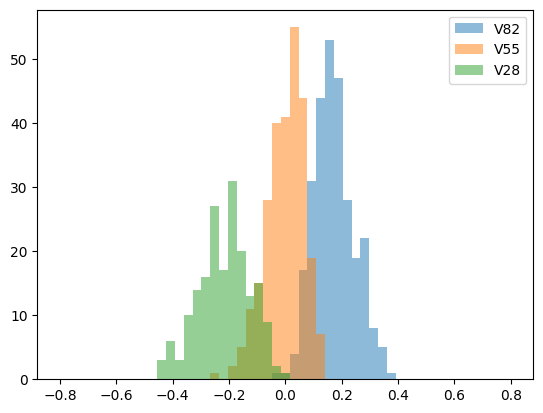

In [ ]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(mean_V82) + np.mean(mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(mean_V55) + np.mean(mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(mean_V28) + np.mean(mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [ ]:
mean_error_centroid = (abs(x0N_V28 + 0.2) + abs(x0N_V82 - 0.2)) / 2
mean_std = (sigmaN_V28 + sigmaN_V55 + sigmaN_V82) / 3
epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
print('Mean FWHM: %.3f  Mean BIAS: %.3f Epsilon: %.3f' % (mean_std, mean_error_centroid, epsilon))

Mean FWHM: 0.077  Mean BIAS: 0.024 Epsilon: 0.081
